# Simple Regression model with target feature price 

Now that we have a clean dataframe with no multicollinearity, we can attempt to create a simle model first. After we can attempt to create a multi feature model. Again, our target feature is price.

**Main Goals for model fitting:**
* Fit an intial regression model. Using statistical analysis look at the p-value of features and determine which features are important. 
* Test for normality using Jarqu-Bera test. Test for heteroscedasticity. 
* From the tests we can refine and improve our model. 

In [73]:
#import all neccesary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

import statsmodels.api as sm
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

There are 4 main assumptions for regression models: 
1. Linearity 
> There needs to be a linear relationship between the target variable and the predictors being used. 
2. Normality 
> The residual erros from the model are to be assumed as normally distributed. This can be checked using a Qunatile-Quantile Plot. 
3. Homoscedasticity 
> The residual erros from the model should not be correlated with the target variable or any predictors. This can be viewed through a residual plot. The erros must bve random. 

In [74]:
# read cleaned dataframe
clean = pd.read_csv('../data/clean.csv', index_col=0)
clean.head()

,price_log,sqft_lot_log,sqft_above_log,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_1,greenbelt_1,...,zipcode_90.0,zipcode_91.0,zipcode_92.0,zipcode_93.0,zipcode_94.0,zipcode_95.0,zipcode_96.0,zipcode_97.0,zipcode_98.0,zipcode_99.0
21177,12.422989,10.591823,7.489971,3,1.5,1.0,4,7,0,0,...,0,0,0,0,0,0,0,0,0,0
10844,13.319574,9.462343,7.710653,4,1.5,1.5,4,7,0,0,...,0,0,0,0,0,0,0,0,0,0
9292,13.835313,9.626152,7.229839,5,2.0,1.0,4,8,0,0,...,0,0,0,0,0,0,0,0,0,0
17878,13.321214,9.651945,7.098376,5,2.0,1.0,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0
14450,13.458836,9.061840,7.450080,3,2.0,1.5,5,7,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model 1 with with all features included and target variable price_log

In [75]:
# Specify the model parameters
X = clean.drop(labels='price_log', axis=1)
y = clean['price_log']

# Create model
model1 = sm.OLS(y, sm.add_constant(X))
model1_results = model1.fit()
print(model1_results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     197.4
Date:                Wed, 26 Jul 2023   Prob (F-statistic):               0.00
Time:                        13:32:41   Log-Likelihood:                -8322.2
No. Observations:               30110   AIC:                         1.735e+04
Df Residuals:                   29758   BIC:                         2.027e+04
Df Model:                         351                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9

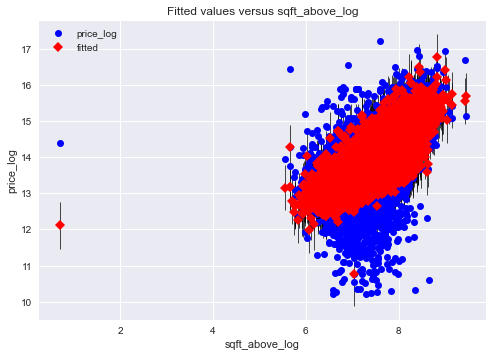

In [76]:
sm.graphics.plot_fit(model1_results, "sqft_above_log")
plt.show()

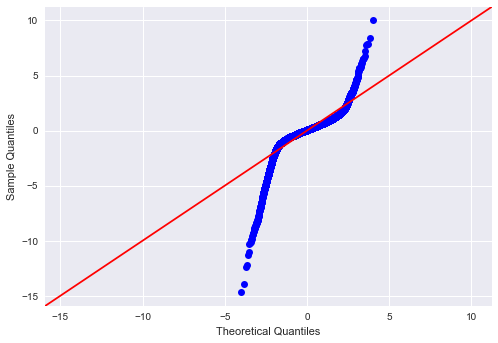

In [77]:
sm.graphics.qqplot(model1_results.resid, dist=stats.norm, line='45', fit=True)
plt.show()

In [78]:
# Obatin residuals
residuals = model1_results.resid

# calculate squared residuals
squared_residuals = residuals**2

# Calculate Mean Squared Err
mse = np.mean(squared_residuals)

print("Mean Squared Err:", mse)

Mean Squared Err: 0.10176505179945569


**Observations:**
* Overall the model is statistically significant with the F-statistic p-value less than 0.05.
* The model explains about 70% percent of the variance in price_log
* There are non statistically significant features that include some of the zipcodes, bedrooms, garage 1.0, heat_Gas/Oil
* The model dooes not do great when pridicting small or large values as we can see with the qq plot.
* The model does well in only a certain range of values which probably explains the MSE value which is close to zero. 

Eliminate any features above 0.05 p-value

It seems we still have some features that are still not statistically significant so lets try again

In [83]:
import pandas as pd
import statsmodels.api as sm

# Specify the model parameters
X = clean.drop(labels='price_log', axis=1)
y = clean['price_log']

# Fit the initial model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Continue the loop while there are high p-values
while model.pvalues.drop('const').max() > 0.05:
    # Extract feature names and corresponding p-values
    feature_p_values = model.pvalues.drop('const')  # Drop the intercept p-value
    
    # Filter features with p-values > 0.05
    features_with_high_p_value = feature_p_values[feature_p_values > 0.05]
    
    # Remove features with high p-values from the dataset
    features_to_drop = features_with_high_p_value.index.intersection(X.columns)
    X = X.drop(features_to_drop, axis=1)
    
    # Fit the updated model
    X = sm.add_constant(X)  # Add the constant column again
    model = sm.OLS(y, X).fit()

In [84]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     622.7
Date:                Wed, 26 Jul 2023   Prob (F-statistic):               0.00
Time:                        13:35:12   Log-Likelihood:                -8433.0
No. Observations:               30110   AIC:                         1.709e+04
Df Residuals:                   29998   BIC:                         1.802e+04
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9

Still have some non-statical features

In [49]:
# from sklearn.preprocessing import PolynomialFeatures
# # Specify the model parameters
# X = clean.drop(labels='price_log', axis=1)
# y = clean['price_log']

# poly = PolynomialFeatures(2)
# X_poly = poly.fit_transform(X)
# feature_names = poly.get_feature_names(input_features=X.columns)
# X_poly = pd.DataFrame(X_poly, columns=feature_names, index=X.index)

## Model 2 with top 3 features

In [11]:
# Specify the model parameters
X = model1_df[['extracted_grade_num', 'sqft_above', 'bathrooms']]
y = clean['price_log']

In [13]:
model2 = sm.OLS(y, sm.add_constant(X))
model2_results = model1.fit()
print(model1_results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     7088.
Date:                Tue, 25 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:23:57   Log-Likelihood:                -18382.
No. Observations:               30110   AIC:                         3.677e+04
Df Residuals:                   30106   BIC:                         3.680e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  11.7419    

## Model 3 with the transformed features

In [14]:
transformed = pd.read_csv("../data/transformed_clean.csv", index_col=0)

In [15]:
transformed.head()

,price_log,bedrooms,bathrooms,floors,condition_num,extracted_grade_num,waterfront_YES,greenbelt_YES,basement_1.0,sewer_PUBLIC,heat_Electricity/Solar,heat_Gas,heat_Gas/Solar,heat_Oil,sqft_lot_log,sqft_above_log,garage,patio
21177,12.422989,3,1.5,1.0,4,7,0,0,0,1,0,0,0,1,10.591823,7.489971,1,1
10844,13.319574,4,1.5,1.5,4,7,0,0,0,1,0,1,0,0,9.462343,7.710653,1,1
9292,13.835313,5,2.0,1.0,4,8,0,0,1,1,0,0,0,1,9.626152,7.229839,0,0
17878,13.321214,5,2.0,1.0,3,7,0,0,1,0,0,0,0,1,9.651945,7.098376,0,1
14450,13.458836,3,2.0,1.5,5,7,0,0,0,1,0,1,0,0,9.061840,7.450080,0,0


In [17]:
# Define our model3 dataframe
model3_df = transformed.drop(labels='price_log', axis=1)

# Define model parameters
X = model3_df
y = transformed['price_log']

# Craete model 
model3 = sm.OLS(y, sm.add_constant(X))
model3_results = model3.fit()
print(model3_results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     1611.
Date:                Tue, 25 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:48:11   Log-Likelihood:                -16682.
No. Observations:               30110   AIC:                         3.340e+04
Df Residuals:                   30092   BIC:                         3.355e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8

**Observations:**
* The main takeaway from this model is that we no longer have the numerical problems err from our model summary
* The model overall is statistically significant with the F-statistic p-value below 0.05 
* The features/feature that are not statistically significant are patio

Lets drop patio from our dataset and create the model again. 

In [18]:
# Define our model3 dataframe
model3_df = transformed.drop(labels=['price_log', 'patio'], axis=1)

# Define model parameters
X = model3_df
y = transformed['price_log']

# Craete model 
model3 = sm.OLS(y, sm.add_constant(X))
model3_results = model3.fit()
print(model3_results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     1712.
Date:                Tue, 25 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:06:41   Log-Likelihood:                -16682.
No. Observations:               30110   AIC:                         3.340e+04
Df Residuals:                   30093   BIC:                         3.354e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8

In [19]:
clean.corr()['price_log'].sort_values(ascending=False)

price_log                 1.000000
extracted_grade_num       0.614471
sqft_above                0.548116
bathrooms                 0.516526
bedrooms                  0.345930
sqft_patio                0.310323
sqft_garage               0.284608
floors                    0.234231
heat_Gas                  0.183325
waterfront_YES            0.138611
basement_1.0              0.136989
greenbelt_YES             0.097197
sqft_lot                  0.084713
heat_Gas/Solar            0.036587
sewer_PUBLIC              0.032915
condition_num             0.009101
heat_Electricity/Solar   -0.015479
heat_Oil                 -0.081566
Name: price_log, dtype: float64

In [21]:
# Specify the model parameters
X = model3_df[['extracted_grade_num', 'sqft_above_log', 'bathrooms']]
y = transformed['price_log']

# Craete model 
model3 = sm.OLS(y, sm.add_constant(X))
model3_results = model3.fit()
print(model3_results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     6945.
Date:                Tue, 25 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:14:16   Log-Likelihood:                -18508.
No. Observations:               30110   AIC:                         3.702e+04
Df Residuals:                   30106   BIC:                         3.706e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.6282    